## Appraisal model v.1
appraisal model using xgboost

### Import Libraries and Read preprocessed data

In [202]:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error as MAE 
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import statistics

In [203]:
df = pd.read_csv('../AppraisalDataPreprocessing/preprocessed_data.csv')
df.head(5)

,num__car_year,num__model_year_start,num__model_year_end,num__mile,nom__model_3,nom__model_BT-50 PRO,nom__model_CX-3,nom__model_CX-30,nom__model_CX-5,nom__model_CX-8,...,nom__color_gray,nom__color_green,nom__color_other,nom__color_red,nom__color_silver,nom__color_sky,nom__color_white,Id,cost,car_model
0,-0.680002,-2.014420,-1.817434,0.851441,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,245000,Mazda 2 1.5 Sports Maxx Sports Hatchback
1,-1.670146,-1.276841,-1.817434,-0.039278,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,269000,Mazda 3 2.0 Maxx Sports Hatchback
2,1.300286,0.198318,0.917991,-0.722674,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,390000,Mazda 2 1.3 S Leather Sedan
3,1.300286,2.042266,0.917991,-0.031599,0,0,0,1,0,0,...,0,0,0,1,0,0,0,3,650000,Mazda CX-30 2.0 SP SUV
4,-0.349954,0.198318,0.917991,1.043406,0,0,0,0,0,0,...,0,0,0,1,0,0,0,4,357900,Mazda 2 1.3 High Connect Sedan


### Appraise cost using xgboost

get mean of each car model for evaluate

In [204]:
df['car_model_mean'] = df['cost'].groupby(df['car_model']).transform(np.mean)

seperate target column from dataframe

In [205]:
X = df.drop(columns=['cost', 'car_model', 'Id'])
y = df['cost']

splitting data  
train : test = 80 : 20  
stratify by car model

In [206]:
car_model = df['car_model']
df.drop(columns=['car_model'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=car_model, random_state=1234)

In [207]:
X_train.drop(columns=['car_model_mean'], inplace=True)
car_model_mean = X_test['car_model_mean']
X_test.drop(columns=['car_model_mean'], inplace=True)

In [208]:
# one2car = pd.read_csv('../AppraisalDataPreprocessing/data_one2car.csv')
# one2car.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
# test = X_test[['Id']].merge(one2car, on='Id')
# test.to_csv('test_dataset.csv')

In [209]:
ttb_id = pd.read_csv('test_dataset_ttb_id.csv')
ttb_bluebook = pd.read_excel('ttb_bluebook.xlsx')
ttb_bluebook.rename(columns={'Unnamed: 0':'ttb_bluebook_id'}, inplace=True)
ttb_id = ttb_id.merge(ttb_bluebook[['avg_used_price', 'ttb_bluebook_id']], how='left', on='ttb_bluebook_id')
ttb_id['avg_used_price'].fillna(value=ttb_id['avg_used_price'].mean(), inplace=True)
estimated_price = ttb_id['avg_used_price']
estimated_price

0       620000.0
1       480000.0
2       525000.0
3      1170000.0
4       235000.0
         ...    
430     430000.0
431     660000.0
432     450000.0
433     235000.0
434     970000.0
Name: avg_used_price, Length: 435, dtype: float64

Use xgboost model to appraise the value

In [210]:
import pickle

model_file = open('./models2/xgboost.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [211]:
pred = model.predict(X_test)

### Evaluate model

In [212]:
result_cols = ['model', 'mae', 'mse', 'rmse', 'mape', 'r2']
result_df = pd.DataFrame(columns=result_cols)

standard deviation of car price

In [213]:
sd = statistics.stdev(y_test)
print(sd)

185489.10530089893


#### Mean price of each car model

In [214]:
mae = MAE(y_test, car_model_mean)
mse = MSE(y_test, car_model_mean, squared=True)
rmse = MSE(y_test, car_model_mean, squared=False)
mape = MAPE(y_test, car_model_mean)
r2 = r2_score(y_test, car_model_mean)

result = {'model':'mean price', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### Estimated price of each car from ttb bluebook

VAT 7% has been included to ttb bluebook estimated price

In [215]:
estimated_price = estimated_price/1.07

In [216]:
mae = MAE(y_test, estimated_price)
mse = MSE(y_test, estimated_price, squared=True)
rmse = MSE(y_test, estimated_price, squared=False)
mape = MAPE(y_test, estimated_price)
r2 = r2_score(y_test, estimated_price)

result = {'model':'ttb bluebook', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### XGBoost

In [217]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'xgboost', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [218]:
result_df

,model,mae,mse,rmse,mape,r2
0,mean price,54430.452623,6.043130e+09,77737.574557,0.122708,0.823955
1,ttb bluebook,64602.434698,8.458107e+09,91967.969289,0.151228,0.753603
2,xgboost,38734.157148,3.374354e+09,58089.192258,0.090079,0.901700


#### Decision tree

In [219]:
model_file = open('./models2/decision_tree.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [220]:
pred = model.predict(X_test)

In [221]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'decision tree', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### Random Forest

In [222]:
model_file = open('./models2/random_forest.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [223]:
pred = model.predict(X_test)

In [224]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'random forest', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### XGBoostRFRegressor

In [225]:
model_file = open('./models2/xgboostrf.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [226]:
pred = model.predict(X_test)

In [227]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'xgboostrf', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### CatBoost

In [228]:
model_file = open('./models2/catboost.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [229]:
pred = model.predict(X_test)

In [230]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'catboost', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### LightGBM

In [231]:
model_file = open('./models2/lightgbm.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [232]:
pred = model.predict(X_test)

In [233]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'lightgbm', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### SVR

In [ ]:
model_file = open('./models2/svr.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [ ]:
pred = model.predict(X_test)

In [ ]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'svr', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### Linear Regression

In [ ]:
model_file = open('./models2/lr.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [ ]:
pred = model.predict(X_test)

In [ ]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'linear regression', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

### Result

In [234]:
result_df

,model,mae,mse,rmse,mape,r2
0,mean price,54430.452623,6.043130e+09,77737.574557,0.122708,0.823955
1,ttb bluebook,64602.434698,8.458107e+09,91967.969289,0.151228,0.753603
2,xgboost,38734.157148,3.374354e+09,58089.192258,0.090079,0.901700
3,decision tree,43495.016829,4.137417e+09,64322.759754,0.099694,0.879471
4,random forest,37976.916409,3.000376e+09,54775.691535,0.087624,0.912595
5,xgboostrf,39594.447486,3.361655e+09,57979.782700,0.090518,0.902070
6,catboost,39186.359790,3.070393e+09,55411.127910,0.091633,0.910555
7,lightgbm,40849.105815,3.350000e+09,57879.180710,0.094091,0.902410


In [235]:
model_file = open('./models2/catboost.model', 'rb')

model = pickle.load(model_file)

model_file.close()

In [236]:
pred = model.predict(X_test)

In [237]:
# pred = {
#     'brand': ['Mazda'],
#     'model': ['2'],
#     'sub_model': ['1.3'],
#     'sub_model_name': ['SP Sports'],
#     'car_type': ['Hatchback'],
#     'transmission': ['AT'],
#     'model_year_start': [15],
#     'model_year_end': [15],
#     'color': ['gray'],
#     'car_year': 2022,
#     'mile': [8360]
# }
# tmp = pd.DataFrame(data=pred)

# model_file = open('../AppraisalDataPreprocessing/preprocessor.model', 'rb')

# preprocessor = pickle.load(model_file)

# model_file.close()


# x = preprocessor.transform(tmp)
# x.drop(columns=['num__model_year_start', 'num__model_year_end'], inplace=True)
# model.predict(x)

In [238]:
def absolute_percentage_error_array(y_test, y_pred):
    # Ensure both arrays have the same length
    if len(y_pred) != len(y_test):
        raise ValueError("Arrays must have the same length.")

    # Calculate absolute percentage error for each pair of values
    abs_percentage_errors = [abs((y_t - y_p) / y_t) * 100 for y_t, y_p in zip(y_test, y_pred)]

    return abs_percentage_errors

abs_percentage_errors = absolute_percentage_error_array(y_test, pred)
print("Absolute Percentage Errors:", abs_percentage_errors)

Absolute Percentage Errors: [57.0109829604842, 8.5569463489211, 1.47472231433853, 19.898514908047098, 53.39274203962368, 13.831871220469871, 20.69000506446065, 6.312684482267985, 17.69967297127173, 1.414472840595046, 3.055722275120442, 6.430088385107019, 3.043474746553898, 10.130730981820872, 24.422372465938057, 4.4277510455059215, 11.183870743788198, 4.965548577169359, 2.435296721060248, 18.60924807680462, 11.335999643262543, 7.156332177229757, 0.5284960855779457, 5.772013679735015, 1.2326004249443978, 0.06910058693011181, 17.312202553485413, 13.756767622945368, 11.572801042501101, 6.175648687461434, 1.5441112099331074, 3.318045350033653, 13.626623163051235, 10.640628353929094, 6.653496629667542, 17.067638496735515, 2.9273293542083447, 10.632063102455314, 10.10359043673781, 1.032461172275192, 14.90505503065355, 8.48501632487376, 1.6482659173324365, 9.1185527799786, 5.806515044911359, 0.3159640749457889, 1.2534877742495456, 7.157873870231731, 0.3629496668976341, 18.478906087273703, 16.

In [239]:
def percentage_error_array(y_test, y_pred):
    # Ensure both arrays have the same length
    if len(y_pred) != len(y_test):
        raise ValueError("Arrays must have the same length.")

    # Calculate absolute percentage error for each pair of values
    percentage_errors = [(y_p - y_t) / y_t * 100 for y_t, y_p in zip(y_test, y_pred)]

    return percentage_errors

percentage_errors = percentage_error_array(y_test, pred)
print("Percentage Errors:", percentage_errors)

Percentage Errors: [57.0109829604842, -8.5569463489211, -1.47472231433853, -19.898514908047098, 53.39274203962368, 13.831871220469871, -20.69000506446065, -6.312684482267985, -17.69967297127173, 1.414472840595046, -3.055722275120442, 6.430088385107019, -3.043474746553898, -10.130730981820872, 24.422372465938057, -4.4277510455059215, 11.183870743788198, -4.965548577169359, -2.435296721060248, -18.60924807680462, 11.335999643262543, -7.156332177229757, -0.5284960855779457, 5.772013679735015, 1.2326004249443978, -0.06910058693011181, -17.312202553485413, 13.756767622945368, 11.572801042501101, -6.175648687461434, 1.5441112099331074, -3.318045350033653, -13.626623163051235, -10.640628353929094, -6.653496629667542, 17.067638496735515, -2.9273293542083447, 10.632063102455314, -10.10359043673781, -1.032461172275192, 14.90505503065355, 8.48501632487376, -1.6482659173324365, -9.1185527799786, 5.806515044911359, -0.3159640749457889, -1.2534877742495456, 7.157873870231731, 0.3629496668976341, 18.

In [240]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})

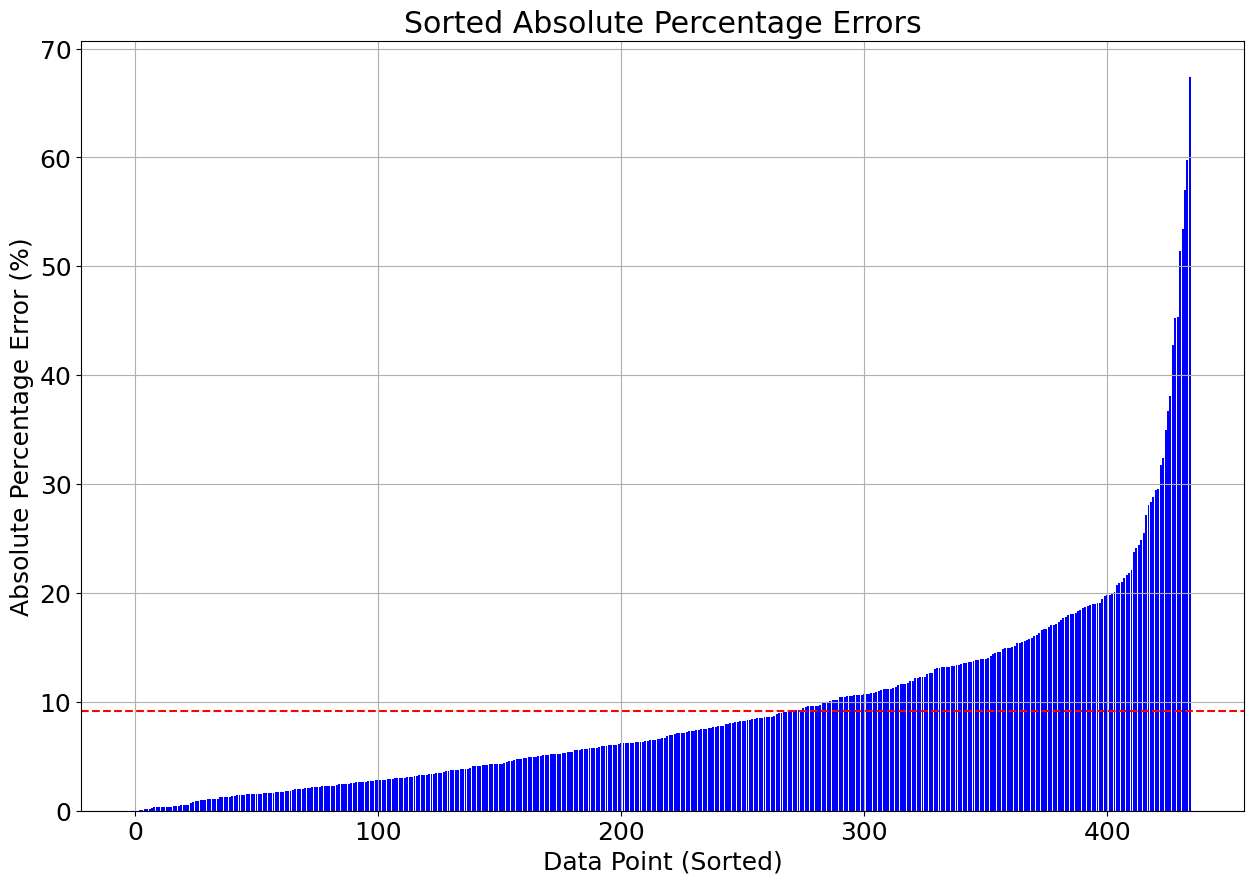

In [241]:
abs_percentage_errors = absolute_percentage_error_array(y_test, pred)

# Sort the absolute percentage errors and get the corresponding indices
sorted_indices = sorted(range(len(abs_percentage_errors)), key=lambda k: abs_percentage_errors[k])

# Sort the absolute percentage errors
sorted_errors = [abs_percentage_errors[i] for i in sorted_indices]

# Plotting the sorted absolute percentage errors
plt.figure(figsize=(15,10))
plt.bar(range(len(sorted_errors)), sorted_errors, color='blue')
plt.grid()
plt.axhline(y=sum(sorted_errors) / len(sorted_errors), color='red', linestyle='--', label='Mean Error')
plt.xlabel('Data Point (Sorted)')
plt.ylabel('Absolute Percentage Error (%)')
plt.title('Sorted Absolute Percentage Errors')
plt.show()

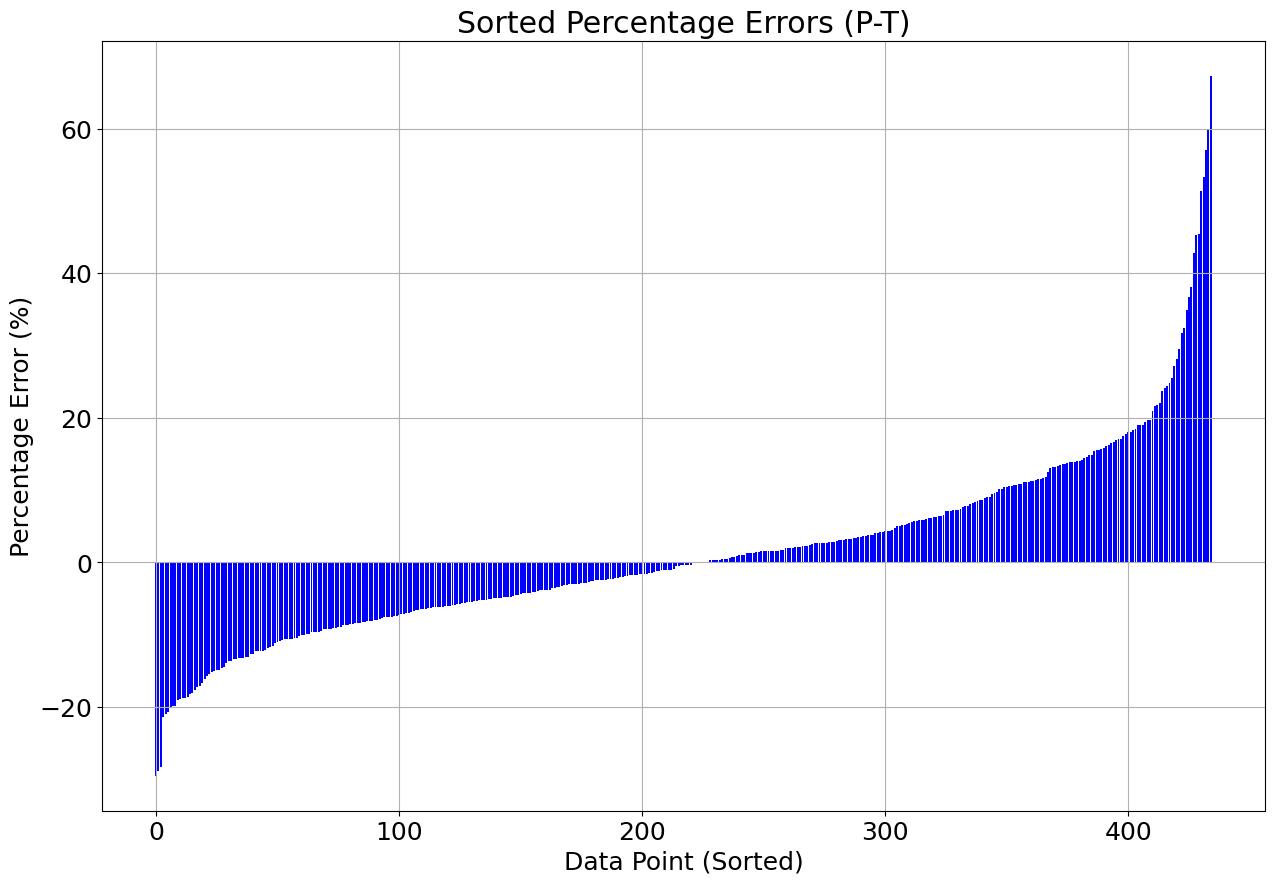

In [242]:
percentage_errors = percentage_error_array(y_test, pred)

# Sort the absolute percentage errors and get the corresponding indices
sorted_indices = sorted(range(len(percentage_errors)), key=lambda k: percentage_errors[k])

# Sort the absolute percentage errors
sorted_errors = [percentage_errors[i] for i in sorted_indices]

# Plotting the sorted absolute percentage errors
plt.figure(figsize=(15,10))
plt.bar(range(len(sorted_errors)), sorted_errors, color='blue')
plt.grid()
plt.xlabel('Data Point (Sorted)')
plt.ylabel('Percentage Error (%)')
plt.title('Sorted Percentage Errors (P-T)')
plt.show()

Absolute Percentage Errors: [76.65830863916113, 12.43060923336378, 8.073613569928764, 27.294289164753614, 23.385487766460148, 20.106594602709887, 32.661306778761784, 4.766516552870733, 27.959501557632404, 5.093270277371163, 1.7390275641783919, 10.280373831775691, 15.153357141048046, 10.665200659703146, 6.7413065135917165, 1.6195109461016366, 9.490478238767446, 7.967757141013789, 0.9721504719860925, 27.918075164048524, 13.973102347845897, 9.803725840060883, 6.652006597031332, 3.6999103827934956, 22.926664982739737, 36.338647608576125, 0.012243398767502014, 3.9460020768432065, 20.125891934747607, 5.568535825545175, 8.106205763891605, 7.515576323987544, 0.6145602251169515, 6.2070813653569195, 2.1951749619648004, 11.760799494646816, 2.151706150836774, 6.896341090953505, 44.631227932778835, 14.289012282545514, 18.946474086661, 17.147840574805393, 2.38982201599024, 8.798537747652665, 3.575137219997046, 18.82183579736306, 3.5745254841506826, 11.941269882591824, 9.277105925941333, 21.643673045

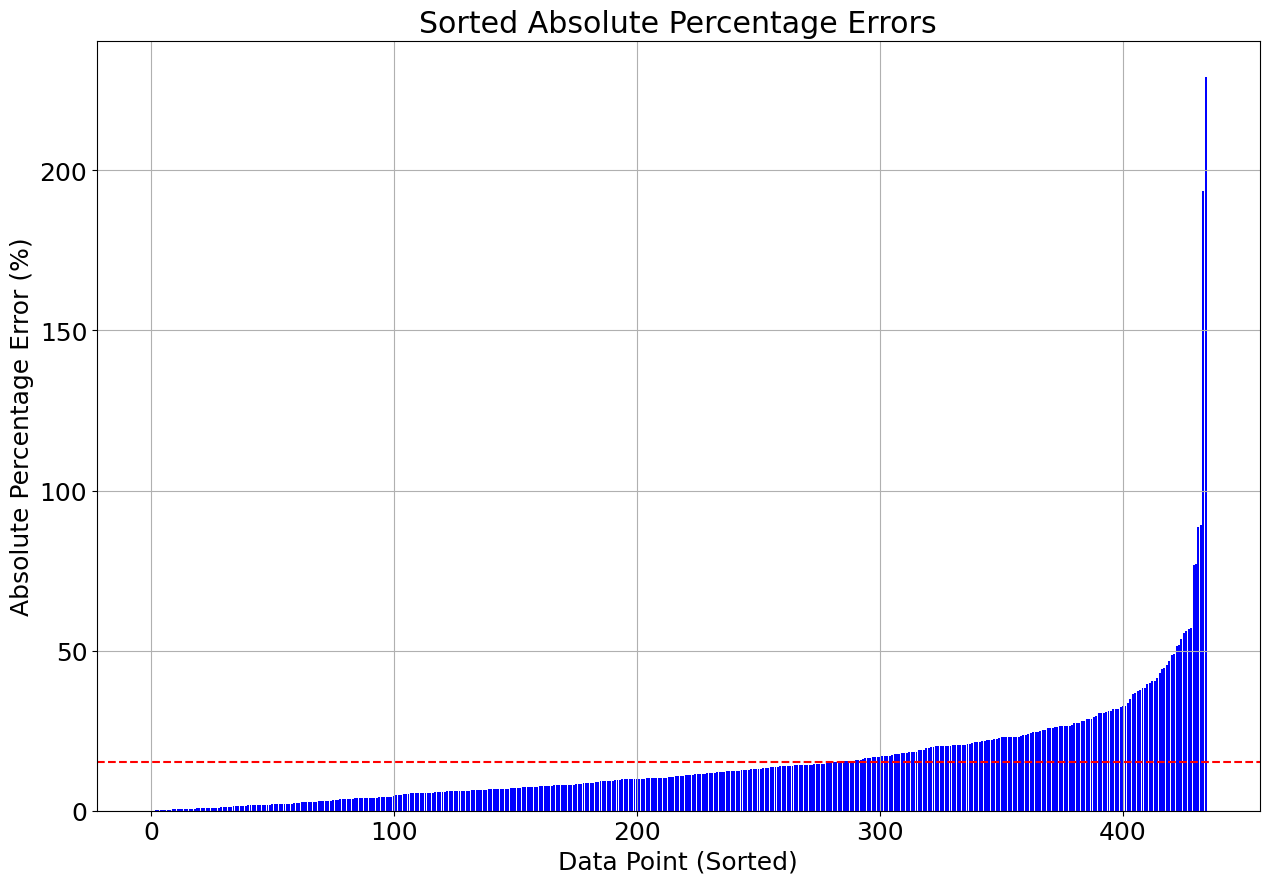

In [243]:
abs_percentage_errors = absolute_percentage_error_array(y_test, estimated_price)
print("Absolute Percentage Errors:", abs_percentage_errors)

# Sort the absolute percentage errors and get the corresponding indices
sorted_indices = sorted(range(len(abs_percentage_errors)), key=lambda k: abs_percentage_errors[k])

# Sort the absolute percentage errors
sorted_errors = [abs_percentage_errors[i] for i in sorted_indices]

# Plotting the sorted absolute percentage errors
plt.figure(figsize=(15,10))
plt.bar(range(len(sorted_errors)), sorted_errors, color='blue')
plt.grid()
plt.axhline(y=sum(sorted_errors) / len(sorted_errors), color='red', linestyle='--', label='Mean Error')
plt.xlabel('Data Point (Sorted)')
plt.ylabel('Absolute Percentage Error (%)')
plt.title('Sorted Absolute Percentage Errors')
plt.show()

Absolute Percentage Errors: [45.8138756692445, 19.867045662937834, 0.44190528634361237, 26.42392244786501, 28.838951310861425, 2.86144578313253, 9.64792576419214, 5.243287078395167, 18.97727272727273, 4.631024096385542, 2.5616619028174763, 9.728273563218396, 13.857994579945798, 7.752639517345404, 68.62944162436548, 12.034246575342465, 10.240035234529842, 8.447854461502105, 2.6127038068038027, 3.4332688588007665, 5.041040338460939, 4.775255896751219, 34.45382698961937, 10.259220231822978, 0.38603073661897314, 31.092346020761248, 1.0917121542940362, 1.1640211640211702, 41.03891203498509, 5.326086956521734, 8.027035725780491, 23.636791087962955, 15.93600253455309, 17.844354838709677, 9.472095471236226, 9.535269700665433, 10.492689422355589, 1.5264161220043573, 3.091134916938368, 4.319014319014317, 38.91772727272727, 6.39640204271123, 10.271950271950276, 14.562514551804423, 4.133597883597884, 0.05541972290139023, 0.32731687466088283, 7.96697460972726, 0.6667594654788419, 23.57777443609023,

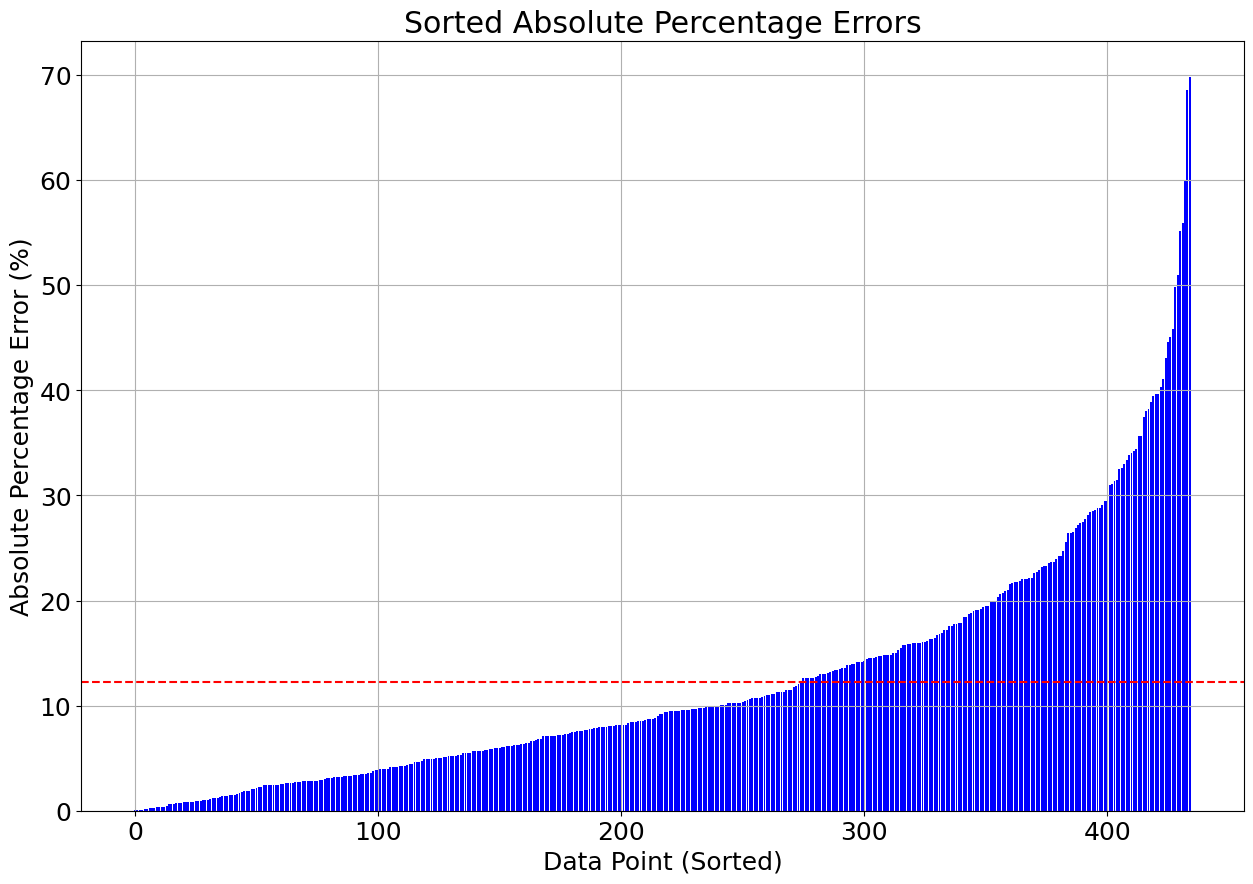

In [244]:
abs_percentage_errors = absolute_percentage_error_array(y_test, car_model_mean)
print("Absolute Percentage Errors:", abs_percentage_errors)

# Sort the absolute percentage errors and get the corresponding indices
sorted_indices = sorted(range(len(abs_percentage_errors)), key=lambda k: abs_percentage_errors[k])

# Sort the absolute percentage errors
sorted_errors = [abs_percentage_errors[i] for i in sorted_indices]

# Plotting the sorted absolute percentage errors
plt.figure(figsize=(15,10))
plt.bar(range(len(sorted_errors)), sorted_errors, color='blue')
plt.grid()
plt.axhline(y=sum(sorted_errors) / len(sorted_errors), color='red', linestyle='--', label='Mean Error')
plt.xlabel('Data Point (Sorted)')
plt.ylabel('Absolute Percentage Error (%)')
plt.title('Sorted Absolute Percentage Errors')
plt.show()

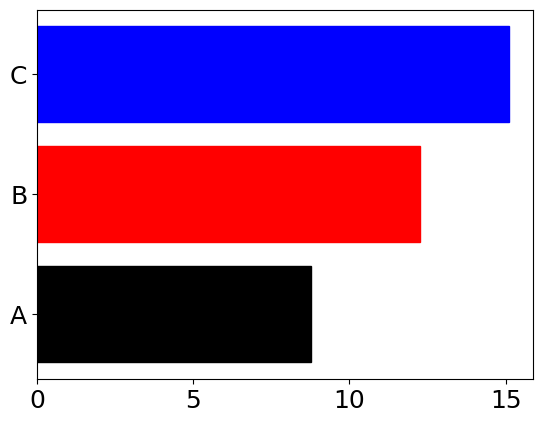

In [245]:
x = np.array(["A", "B", "C"])
y = np.array([result_df['mape'].iloc[4]*100, result_df['mape'].iloc[0]*100, result_df['mape'].iloc[1]*100])

bars = plt.barh(x, y)
bars[0].set_color('black')
bars[1].set_color('red')
bars[2].set_color('blue')
plt.show()